## SelfDrivingCar-P4-Advanced_Lane_Lines_video
Udacity CarND Project 4

Advanced Lane Finding
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.

The Project
The goals / steps of this project are the following:

+ Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
+ Apply a distortion correction to raw images.
+ Use color transforms, gradients, etc., to create a thresholded binary image.
+ Apply a perspective transform to rectify binary image ("birds-eye view").
+ Detect lane pixels and fit to find the lane boundary.
+ Determine the curvature of the lane and vehicle position with respect to center.
+ Warp the detected lane boundaries back onto the original image.
+ Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Camera Calibration

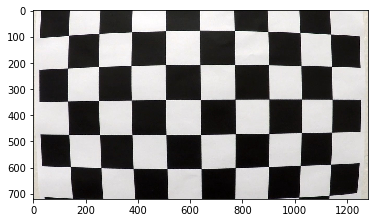

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
import cv2

# Read and check the data
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

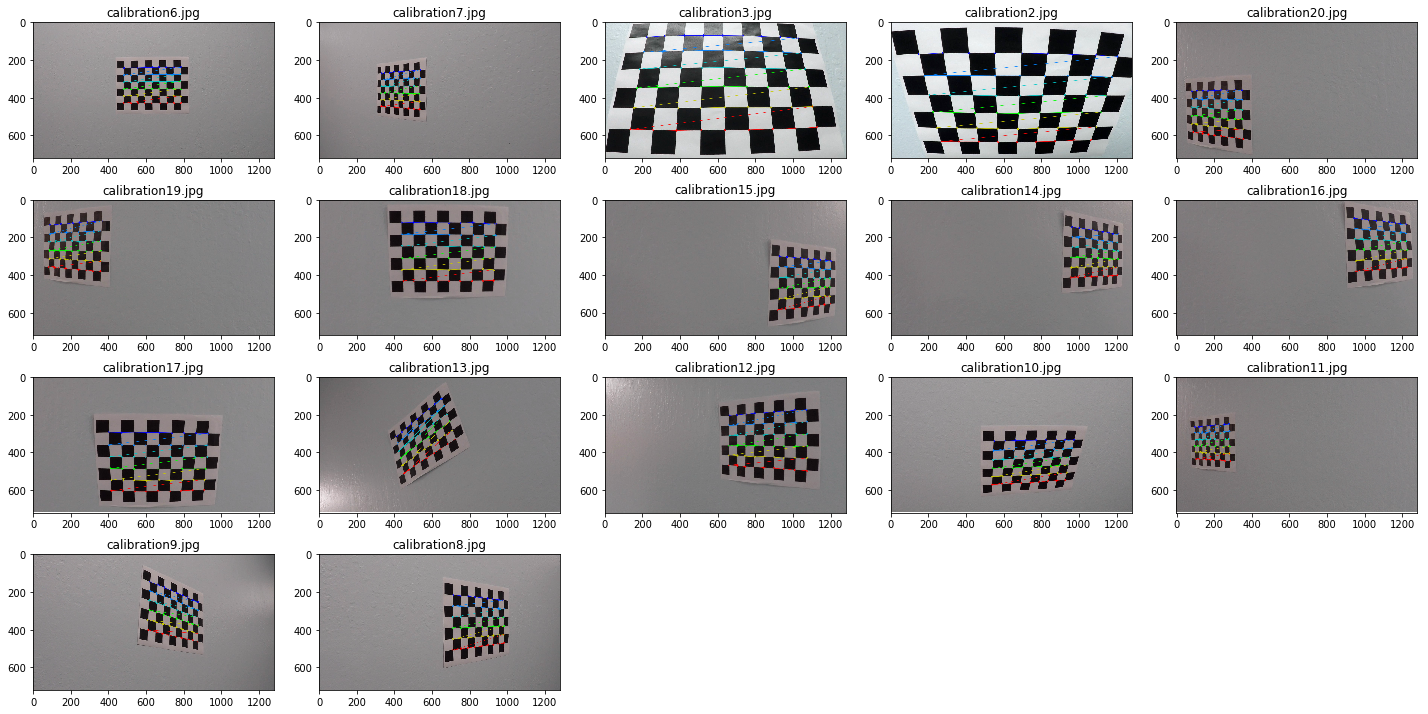

In [2]:
# Find corners
import glob #glob API
images = glob.glob('./camera_cal/calibration*.jpg')

nx, ny = 9, 6
objpoints = [] # 3D points in the real world (x,y,z) from top left to bottom right
imgpoints = [] # 2D points 

# Prepare object points
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates

count = 1
plt.figure(figsize = (20,10))
for fname in images: # not all fname will have corners
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find Corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # draw detected corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.subplot(4, 5, count)
        plt.imshow(img)
        plt.title(fname.split('/')[-1])
        count = count+1
plt.tight_layout()
plt.show()


In [3]:
# Do camera calibration given object points and image points
img = cv2.imread('./test_images/test1.jpg')

img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
np.savez('calibration.npz',mtx=mtx,dist=dist)
print('calibration saved!')

calibration saved!


# Distrotion Correction

In [4]:
def undistort(img,mtx,dist):
    undist_img = cv2.undistort(img, mtx, dist,None,mtx)
    return undist_img


# Perspective view

In [5]:
# Define perspective-view
def perspectiveview(img,src,dst):
    img_size = img.shape[:2][::-1]
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Minv


# Color & Gradient Threshold

In [6]:
# Define threshold function
def sobel(image,sobel_kernel=3):
    # Calculate directional gradient
    # Apply threshold
    if len(image.shape)>2:
        gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1)
    return sobelx,sobely

def abs_sobel_threshold(sobel,thresh=(0,255)):
    # Apply threshold
    abs_sobel = np.absolute(sobel)
    scale_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scale_sobel)
    grad_binary[(scale_sobel>=thresh[0])&(scale_sobel<=thresh[1])]=1
    return grad_binary

def mag_threshold(sobelx,sobely,mag_thresh=(0,255)):
    # Apply threshold
    mag = np.sqrt(sobelx**2 + sobely**2)
    scale_sobel = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(mag)
    mag_binary[(mag>=mag_thresh[0])&(mag<=mag_thresh[1])]=1
    return mag_binary


def dir_threshold(sobelx,sobely,dir_thresh=(0,np.pi/2)):
    # Apply threshold
    angle = np.arctan2(sobely,sobelx)
    dir_binary = np.zeros_like(angle)
    dir_binary[(angle>=dir_thresh[0])&(angle<=dir_thresh[1])]=1
    return dir_binary

def color_threshold(image,s_thresh = (0,255)): #color_threshold
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary


# Detect Lane Lines

In [7]:
def findLines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    histogram = np.sum(binary_warped[0:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img,left_fitx,right_fitx,ploty


In [8]:
def findLines_after(warped):
    bianry_warped = np.unit8(warped)
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    return left_fitx,right_fitx,ploty

# Map back to real world

In [9]:
# Create an image to draw the lines on
def map_back(image,warped,Minv,left_fitx,right_fitx,ploty):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

# Video Test

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
f = np.load('calibration.npz')
mtx = f['mtx']
dist = f['dist']

def process_image(input_image):
    f = np.load('calibration.npz')
    mtx = f['mtx']
    dist = f['dist']

    undist_image = undistort(input_image,mtx,dist)
    
    ksize = 9
    gradthresh = (20,100) # gradient threshold
    sthresh = (100,255) # color threshold
    
    
    sobelx,sobely = sobel(undist_image,sobel_kernel=ksize)
    gradx = abs_sobel_threshold(sobelx,thresh=gradthresh)
    
    s_binary = color_threshold(undist_image,s_thresh=sthresh)
    combined_binary = np.zeros_like(gradx)
    combined_binary[(s_binary==1)|(gradx==1)]=1
 
    src = np.float32([[100,700],[550,480],[750,480],[1200,700]])
    dst = np.float32([[200,700],[200,0],[1000,0],[1000,700]])
    warped,M,Minv = perspectiveview(combined_binary,src,dst)
       
    out_im,left_fitx,right_fitx,ploty = findLines(warped)

    output_image = map_back(undist_image,warped,Minv,left_fitx,right_fitx,ploty)
    return output_image
    

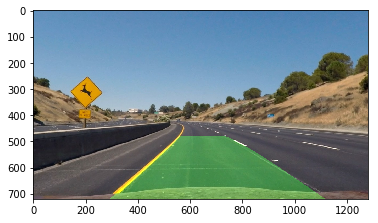

In [12]:
input_image = mpimg.imread('./test_images/test2.jpg')
output_image = process_image(input_image)
plt.figure()
plt.imshow(output_image)


In [13]:
project_video_output = "./output_video/project_video_output.mp4"
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)


[MoviePy] >>>> Building video ./output_video/project_video_output.mp4
[MoviePy] Writing video ./output_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [02:34<00:00,  7.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video_output.mp4 

CPU times: user 2min 49s, sys: 23.8 s, total: 3min 13s
Wall time: 2min 35s


In [ ]:
project_video_output = "./output_video/challenge_video_output.mp4"
clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/challenge_video_output.mp4
[MoviePy] Writing video ./output_video/challenge_video_output.mp4


100%|██████████| 485/485 [01:04<00:00,  8.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/challenge_video_output.mp4 

CPU times: user 1min 4s, sys: 8.27 s, total: 1min 12s
Wall time: 1min 6s


In [ ]:
project_video_output = "./output_video/harder_video_output.mp4"
clip1 = VideoFileClip("./harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/harder_video_output.mp4
[MoviePy] Writing video ./output_video/harder_video_output.mp4


 15%|█▌        | 183/1200 [00:28<02:20,  7.22it/s]